# Classification with BERT features

In [28]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

In [8]:
seed = 2020

df = pd.read_csv('../data/embeded/10000_amazon_reviews_bert.csv')
text_column = 'bert_embedding_mean'
label_column = 'label'

In [9]:
df.head(3)

,bert_embedding_mean,label
0,"[-0.05508401244878769, -0.3134291172027588, 0....",0
1,"[0.1425568014383316, -0.33367687463760376, 0.3...",0
2,"[0.009576206095516682, -0.34511327743530273, 0...",0


 ### Class distribution

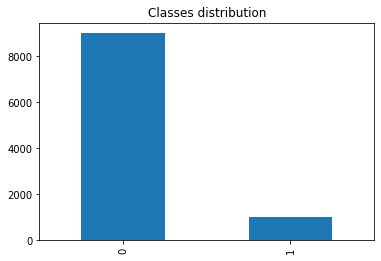

In [10]:
df[label_column].value_counts().plot.bar(title='Classes distribution')

### Train-test split

In [11]:
X = np.array(df[text_column].transform(ast.literal_eval).values.tolist())
y = df[label_column].values
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, 
                                                    test_size=test_size, shuffle=True)
print('Train size: {}'.format(X_train.shape))
print('Test size: {}'.format(X_test.shape))

Train size: (7001, 768)
Test size: (3001, 768)


# Classification with BERT features

In [12]:
# # To Use!
# hyperparams_grid = {
#     'LogisticRegression': {
#         'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'clf__penalty': ['l1', 'l2'],
#         'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
#     },
#     'MultinomialNB': {
#         'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
#     },
#     'LinearSVC': {
#         'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'clf__penalty': ['l1', 'l2'],
#         'clf__loss': ['hinge', 'squared_hinge'],
#         'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
#     },
#     'RandomForestClassifier': {
#         'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
#         'clf__bootstrap': [True, False],
#         'clf__max_depth': [10, 50, 100, None],
#         'clf__max_features': ['auto', 'sqrt'],
#         'clf__min_samples_leaf': [1, 2, 4],
#         'clf__min_samples_split': [2, 5, 10],
#         'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
#     }
# }

# hyperparams grid simplified
hyperparams_grid = {
 'LogisticRegression': {
        'clf__C': [1, 2, 3],
        'clf__penalty': ['l2', 'l1'],
        'clf__class_weight': [{0: 1, 1: 4}, {0: 1, 1: 5}]},
 'MultinomialNB': {
        'clf__alpha': [0.01, 0.1, 1]
    },
 'LinearSVC': {
        'clf__C': [0.1],
        'clf__penalty': ['l2'],
        'clf__loss': ['squared_hinge'],
        'clf__class_weight': ['balanced']
    },
 'RandomForestClassifier': {
    'clf__n_estimators': [600],
    'clf__bootstrap': [False],
    'clf__max_depth': [None],
    'clf__max_features': ['auto'],
    'clf__min_samples_leaf': [2],
    'clf__min_samples_split': [2],
    'clf__class_weight': ['balanced']
    }
}

In [13]:
models = [LogisticRegression(random_state=seed),
          LinearSVC(random_state=seed),
          RandomForestClassifier(random_state=seed)]

k = 5  # number of splits in CV
cv_res = []

for model in models: 
    pipeline  = Pipeline([
    ('clf', model)])
    
    model_name = model.__class__.__name__
    param_grid = hyperparams_grid[model_name]
    grid = GridSearchCV(pipeline, cv=k, param_grid=param_grid, scoring='f1', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    score_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    score_std = grid.cv_results_['std_test_score'][grid.best_index_]
    cv_res.append((model_name, score_mean, score_std, grid.best_params_))
    print('{} f1:{:1.3f} std: {:1.3f}, using {}'.format(model_name, score_mean, score_std, grid.best_params_))
    print('------------------------------------------------')

/Users/evgeny/Documents/wonderful_programming/crowd_ai_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression f1:0.593 std: 0.028, using {'clf__C': 1, 'clf__class_weight': {0: 1, 1: 4}, 'clf__penalty': 'l2'}
------------------------------------------------
LinearSVC f1:0.531 std: 0.030, using {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2'}
------------------------------------------------
RandomForestClassifier f1:0.148 std: 0.037, using {'clf__bootstrap': False, 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 600}
------------------------------------------------


In [14]:
cv_df = pd.DataFrame(cv_res, columns=['model', 'f1_mean', 'f1_std', 'best_params']).set_index('model')
cv_df[['f1_mean', 'f1_std']]

,f1_mean,f1_std
model,,
LogisticRegression,0.593017,0.027860
LinearSVC,0.530662,0.030412
RandomForestClassifier,0.148470,0.036964


# Model Evaluation

In [16]:
model = LogisticRegression(C=10, penalty='l2', class_weight='balanced', random_state=seed)
# model = LinearSVC(C=1, penalty='l2', class_weight='balanced', loss='squared_hinge', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/Users/evgeny/Documents/wonderful_programming/crowd_ai_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Evaluate Model

In [17]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', beta=1)
print('*Evaluation on test data, {}*'.format(model.__class__.__name__))
print('f1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

*Evaluation on test data, LogisticRegression*
f1:  0.5452380952380953
Precision:  0.4232902033271719
Recall:  0.7658862876254181


### Confusion Matrix

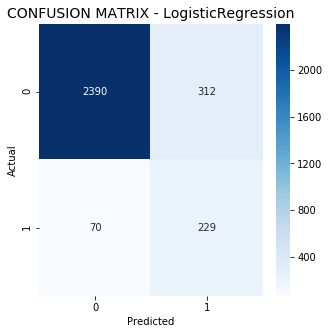

In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
labels = df[label_column].unique()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - {}".format(model.__class__.__name__), size=14);